<h1> 1. Libraries </h1>

Import the libraries needed to the project.

In [ ]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import time
import datetime
from tensorflow.keras.callbacks import EarlyStopping

<h1> 2. Choose the model/ Layer's Sequence </h1>

<p>In total, one can choose 9 distinct models:</p><br>
<ol>
<li><strong>model_='SEQ':</strong> custom sequencial architecture;</li>
<ul>
<li><strong>seq_n_model=1:</strong> Model 4.1 on the Report;</li>
<li><strong>seq_n_model=2:</strong> Model 4.2 on the Report;</li>
<li><strong>seq_n_model=3:</strong> Model 4.3 on the Report;</li>
<li><strong>seq_n_model=4:</strong> Model 4.4 on the Report;</li>
<li><strong>seq_n_model!=all above:</strong> Model 4.5 on the Report;</li>
</ul>

<li><strong>model_='XCEP':</strong> Xception architecture;</li>
<ul>
<li><strong>xcp_n_model=1:</strong> Model 5.1 on the Report;</li>
<li><strong>xcp_n_model!=all above:</strong> Model 5.2 on the Report;</li>
</ul>

<li><strong>model_='XCEP':</strong> Inception V3 architecture;</li>
<ul>
<li><strong>inc_n_model=1:</strong> Model 6.1 on the Report;</li>
<li><strong>inc_n_model!=all above:</strong> Model 6.2 on the Report;</li>
</ul>

</ol>

<p><i>data_aug</i> is a boolean variable created to test to study the effect of using the technique: "Data augmentation", and it's not used in the present project. It was kept to further developments.</p><br>

In [ ]:
model_='SEQ'
data_aug = False
seq_n_model = 5
xcp_n_model = 1
inc_n_model = 2

<h1> 3. Load and define Train/Test datasets</h1>

<ul>
<li>Load Keras' cifar10 data set;</li>
<li>Define train and test datasets (already defined when loading);</li>
<li>For models Xception and Inception V3, resize the shapes to 71x71 and 75x75, respectively, which are the minimum shapes for each model (see the report);</li>
<li>Define <i>data_gen</i> in case of using Data Augmentation;</li>
</ul>
<br>

<strong>Important detail:</strong>
The neural network requires that the inputs be real numbers, and we will do it by forcing the division of the values ​​within the 28x28 matrices (which have values​​ from 0 to 255) by 255.0 (a real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

if model_=='XCP':
  x_train = tf.image.resize(x_train, (71, 71))  # Xception input shape is (71, 71)
  x_test = tf.image.resize(x_test, (71, 71))

if model_=='INC':
  x_train = tf.image.resize(x_train, (75, 75))  # Inception V3 input shape is (75, 75)
  x_test = tf.image.resize(x_test, (75, 75))

if data_aug:
    datagen = ks.preprocessing.image.ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
    )

    train_generator = datagen.flow(x_train, y_train, batch_size=32)
    steps_per_epoch = x_train.shape[0] // 32

y_train_label = y_train


<h2> 3.1 Define an array with all the labels of CIFAR10 </h2>

In [ ]:
cifar10_labels = [
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


<h2> 3.2 Visualize the images </h2>
<p>Paint a sample of the images from the CIFAR10 dataset, to see if it looks anything like what we expect.</p>
<ol>
<li>See what types of data we have; then we .</li>
<li>map those arrays in a grayscale using the <strong>.get_cmap()</strong> method of plotly with the first nine numbers of the dataset</li>
<ol>

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


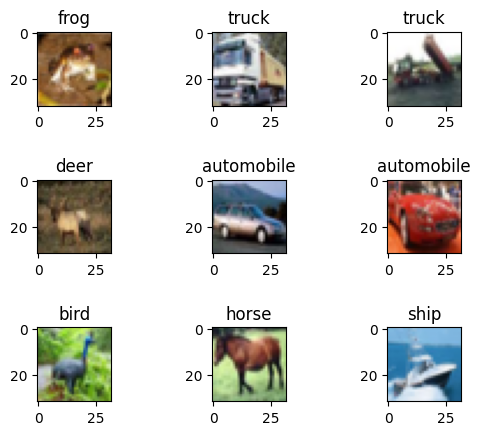

In [ ]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

<h2>3.3 Validate while we train (very practical)</h2>
<p>When convolutions are added, one need to "pre-treat the data", because <strong>the convolution expects an array of 4 fields</strong> (more like "images"), in the case of MNIST. CIFAR10 already has the right shape, so one do not have to do anything, but it's always good practice to check its size.</p>
<p>Therefore, when exiting the Convolution, you have to do a Flatten, because FullDense layers expect arrays, not matrices !!</p>

In [ ]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [ ]:
# We validate the result
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


<h1> 4. Model network architecture </h1>

<p>The model is created according model_ and seq/xcp/inc_n_model chose at point 2. (Details of each model on the report)</p>

<h2>4.1 Model defintion/ building</h2>

In [ ]:
##### CUSTOM MODEL ######

if model_=='SEQ':

    if seq_n_model == 1:

        # Define the Sequential model
        model = ks.models.Sequential([
        ks.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(128, (3,3), activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(256, (3,3), activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Flatten(),
        ks.layers.Dense(256, activation='relu'),
        ks.layers.Dense(128, activation='relu'),
        ks.layers.Dense(10, activation='softmax')
    ])

    elif seq_n_model == 2:

        # Define the Sequential model
        model = ks.models.Sequential([
        ks.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(128, (3,3), activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(256, (3,3), activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Flatten(),
        ks.layers.Dense(256, activation='relu'),
        ks.layers.Dropout(0.5), # Dropout after 256 filters' dense
        ks.layers.Dense(128, activation='relu'),
        ks.layers.Dropout(0.5), # Dropout after 128 filters' dense
        ks.layers.Dense(10, activation='softmax')
    ])

    elif seq_n_model == 3:

        # Define the Sequential model
        model = ks.models.Sequential([
        ks.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Flatten(),
        ks.layers.Dense(128, activation='relu'),
        ks.layers.Dropout(0.5), # Dropout after 256 filters' dense
        ks.layers.Dense(10, activation='softmax')
    ])

    elif seq_n_model == 4:

        # Define the Sequential model
        model = ks.models.Sequential([
        ks.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        ks.layers.BatchNormalization(),
        ks.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Flatten(),
        ks.layers.Dense(128, activation='relu'),
        ks.layers.Dropout(0.5), # Dropout after 128 filters' dense
        ks.layers.Dense(10, activation='softmax')
    ])

    else:

        # Define the Sequential model
        model = ks.models.Sequential([
        ks.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        ks.layers.BatchNormalization(),
        ks.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Dropout(0.4), # Dropout after 2 convs with 32 filters each
        ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Dropout(0.4), # Dropout after 2 convs with 64 filters each
        ks.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.MaxPooling2D((2, 2)),
        ks.layers.Dropout(0.5), # Dropout after 2 convs with 128 filters each
        ks.layers.Flatten(),
        ks.layers.Dense(128, activation='relu'),
        ks.layers.BatchNormalization(),
        ks.layers.Dropout(0.5),
        ks.layers.Dense(10, activation='softmax')
    ])

##### XCEPTION MODEL ######

if model_=='XCP':

  xception_base = ks.applications.Xception(weights='imagenet', include_top=False, input_shape=(71, 71, 3))

  if xcp_n_model == 1:

    model = ks.models.Sequential([
        xception_base,
        ks.layers.GlobalAveragePooling2D(),
        ks.layers.Dense(256, activation='relu'),
        ks.layers.Dropout(0.5), # Dropout after 256 filters' dense
        ks.layers.Dense(10, activation='softmax')
    ])

  else:

      model = ks.models.Sequential([
          xception_base,
          ks.layers.GlobalAveragePooling2D(),
          ks.layers.Flatten(),
          ks.layers.Dense(128, activation='relu'),
          ks.layers.BatchNormalization(),
          ks.layers.Dropout(0.5), # Dropout after 128 filters' dense
          ks.layers.Dense(10, activation='softmax')
      ])

  for layer in xception_base.layers:
      layer.trainable = False

##### INCEPTION V3 MODEL ######

if model_=='INC':

  inception_base = ks.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

  if xcp_n_model == 1:

    model = ks.models.Sequential([
        inception_base,
        ks.layers.GlobalAveragePooling2D(),
        ks.layers.Dense(256, activation='relu'),
        ks.layers.Dropout(0.5), # Dropout after 256 filters' dense
        ks.layers.Dense(10, activation='softmax')
    ])

  else:

      model = ks.models.Sequential([
          inception_base,
          ks.layers.GlobalAveragePooling2D(),
          ks.layers.Flatten(),
          ks.layers.Dense(128, activation='relu'),
          ks.layers.BatchNormalization(),
          ks.layers.Dropout(0.5), # Dropout after 128 filters' dense
          ks.layers.Dense(10, activation='softmax')
      ])

  for layer in inception_base.layers:
      layer.trainable = False

<h2>4.2 Summary of the model</h2>

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

<h1>5. Optimization function/ Loss function/ metrics definition</h1>


In [ ]:
optimizer_ = ks.optimizers.Adam()
model.compile(optimizer=optimizer_,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

<h1>6. Early stopping / Train</h1>

<p>Now the dataset is trained and it was used for most of the models tested <strong>epoch = 100</strong> and an early stopping having <strong>patience = 10</strong> (val_loss and val_accuracy). Only for the tests with data augmentations was used 20 epochs. Such tests are exposed on the report in the Appendix, only for documentation purposes, because the results were so unsatisfatory.</p>
<p>The <strong>.fit()</strong> method allows us to define if we have several CPUs, GPUs, and if we want to validate data at each end of epoch.</p>

<h2> 6.1 Define the Early Stopping </h2>

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=10)
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=10)

<h2> 6.2 Train the model </h2>

In [ ]:
t = time.perf_counter()

In [ ]:
if model_=='SEQ':
  if data_aug:
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                    epochs=20, validation_data=(x_test, y_test))
  else:
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val),
                      callbacks=[callback_accuracy, callback_loss])

if model_=='XCP' or model_=='INC':
  if data_aug:
     history = model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                    epochs=20, validation_data=(x_test, y_test))
  else:
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test),
                        callbacks=[callback_accuracy, callback_loss])

Epoch 1/100
1250/1250 [==============================] - 17s 10ms/step - loss: 1.7618 - accuracy: 0.3931 - val_loss: 1.8949 - val_accuracy: 0.3793
Epoch 2/100
1250/1250 [==============================] - 12s 10ms/step - loss: 1.2168 - accuracy: 0.5680 - val_loss: 1.2095 - val_accuracy: 0.5823
Epoch 3/100
1250/1250 [==============================] - 12s 9ms/step - loss: 1.0525 - accuracy: 0.6304 - val_loss: 0.8372 - val_accuracy: 0.7012
Epoch 4/100
1250/1250 [==============================] - 12s 9ms/step - loss: 0.9368 - accuracy: 0.6753 - val_loss: 0.8310 - val_accuracy: 0.7092
Epoch 5/100
1250/1250 [==============================] - 12s 9ms/step - loss: 0.8660 - accuracy: 0.7020 - val_loss: 0.8541 - val_accuracy: 0.6964
Epoch 6/100
1250/1250 [==============================] - 12s 10ms/step - loss: 0.7968 - accuracy: 0.7255 - val_loss: 0.6884 - val_accuracy: 0.7571
Epoch 7/100
1250/1250 [==============================] - 12s 10ms/step - loss: 0.7547 - accuracy: 0.7399 - val_loss: 0.62

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))
print('Training time:', elapsed_time)

Training time: 0:11:38.943239


<h1>7. Results evaluation<h1>

To evaluate the resuls, one compute the accuracy considering the test dataset.
Then it is created two graphs with the evolution of losses and accuracies (train/validation) along the training (by epoch).

In [ ]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test dataset accuracy > %.3f' % (acc * 100.0))

> 85.510


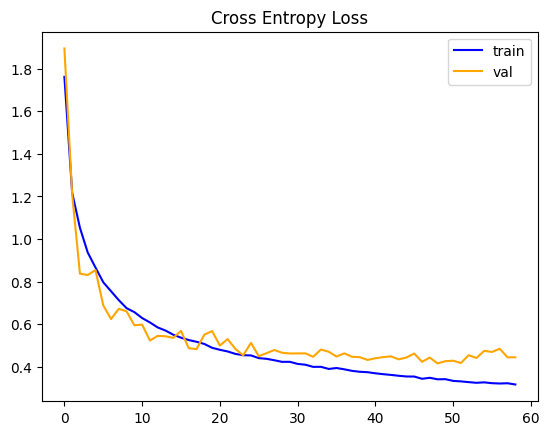

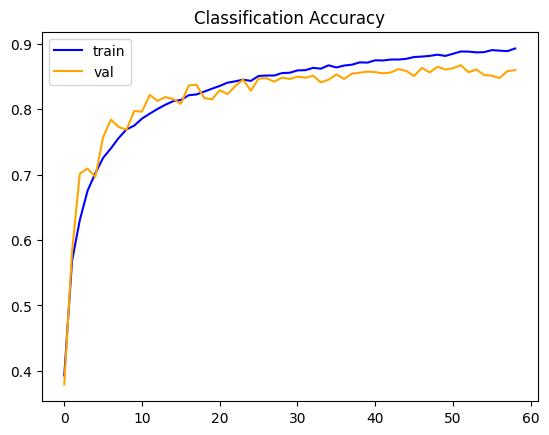

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

<p>By looking for the cost we can see that it is stable after the epoches 25/30. It continuously increase and decrease around the value 0.46. but there are insignificant flutuactions. Regarding the accuracy, 85.93% for the validation dataset and 85.51% for the evaluation with the test dataset is great and seem to be very accurate.</p>
<p>It doesn't exist overfitting because of the tecnhiques used like dropout and batch normalization.</p>
<p>Below one can see some predictions for 20 samples of images, with representation and classifications.</p>

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label[0]].set_color('blue')

<p>The first 20 images are drawned, with the predictions and their real values.</p>
<p>The blue colors on the graphs mean that the prediction was correct, contrarily to the red, which means that the model failed in correctly classifying the image.</p>

0--> airplane
1--> automobile
2--> bird
3--> cat
4--> deer
5--> dog
6--> frog
7--> horse
8--> ship
9--> truck


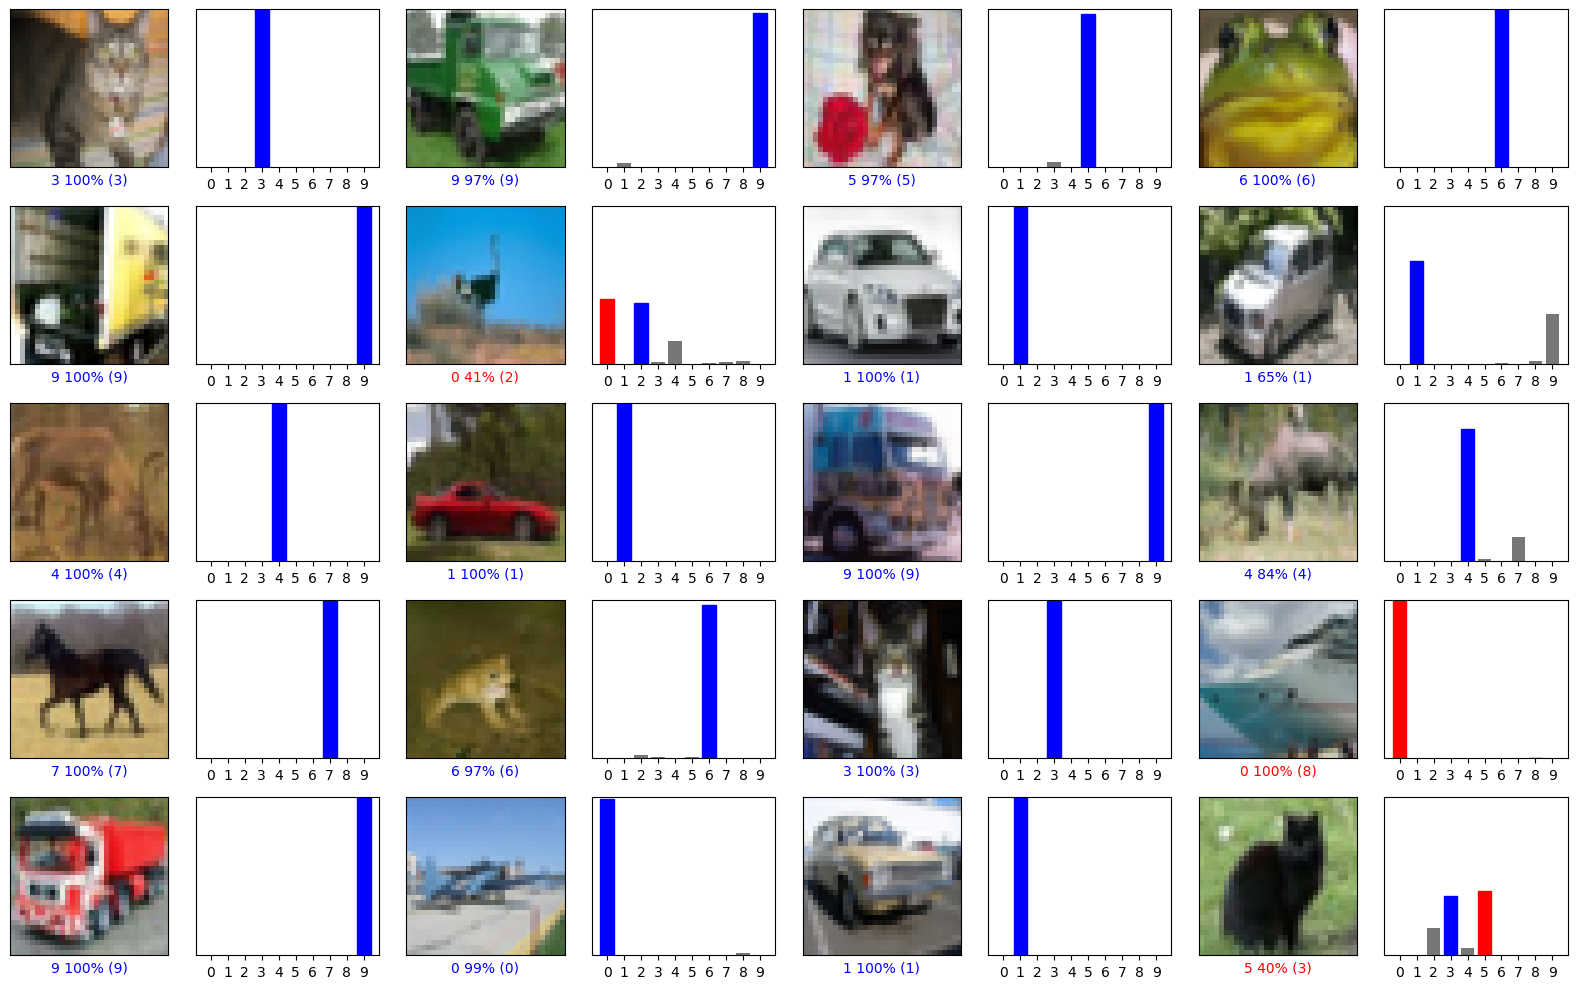

In [ ]:
i = 0
for l in cifar10_labels:
    print(str(i)+"-->", l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

<h1>8. Model saved for future evaluations</h1>

<p>Go changing the names of the file to save the various projects.
Here we save it in "local", but remember that the ideal is that you save it in Google Drive (you have to mount the unit, set the path and save the .h5 model there)</p>

In [ ]:
model.save('cifar10_base_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
